# Accelerations and decelerations from Maeda et al. 2012

## Summary

This notebook implements the method for acceleration and deceleration detection from Maeda et al. 2012, based on the MATLAB implemention in the FHRMA package.

In the [MATLAB code for Maeda](https://github.com/utsb-fmm/FHRMA/blob/master/aammaeda.m), they state that their basic acceleration and deceleration function - used when there is nothing described in a paper - is the same as the function described in Maeda et al - *"Maeda's method with its method for acceleration/deceleration detection which is also the standard simple method for acceleration/deceleration detection"*. However, in their [2020 paper](https://doi.org/10.1016/j.softx.2020.100428), they state that Maeda's method was not described clearly enough to be reprogrammed. Based on the description in the paper (as below), it appears very similar (>15bpm for >15sec), except it does not incorporate the concept of reference lines.

The paper: [Maeda et al. 2012](https://benthamopen.com/contents/pdf/TOMDJ/TOMDJ-4-28.pdf) - Central Computerized Automatic Fetal Heart Rate Diagnosis with a Rapid and Direct Alarm System

This method is **successfully implemented** - all records match between Python and MATLAB.

**Observations:**
* The FHRMA/MATLAB implementation sometimes differed from my interpretation of the paper description. I noticed this to be the case reference lines in accelerations/decelerations, which are described in the paper but not implemented in the code. The description of reference lines in the paper is ambiguous, but I think it might be about finding the average difference between each 2second bpm HR reading and adding that to the 15bpm difference required from baseline

## Paper description of method

Basic acceleration and deceleration detection:
* **Reference line** - "Data-to-data difference in FHR were averaged (F bpm) and added to the baseline data to define the upper reference line (FHR baseline + F/2), and subtracted from the baseline data to define the lower reference line (FHR baseline –F/2)."
* **Deceleration** - "A transient FHR decrease of more than 15 bpm below the lower reference line lasting longer than 15 seconds was defined as a deceleration. An FHR decrease appearing during transient tachycardia with a nadir of 110 bpm or more was not considered a deceleration but instead a transient recovery to the normal baseline."
* **Acceleration** - A transient rise in FHR of 15 bpm or more above the upper reference line lasting 15 seconds or more , after 30 weeks of pregnancy, was defined as FHR acceleration

More nuanced:
* **Late Deceleration** - "The DIP SHAPE value was applied to the classification of deceleration, and was calculated by dividing the dip area ((sum of the FHR data in the deceleration) x 2) by ((deceleration amplitude x duration (seconds)) (Fig. 2). A decrease in FHR was defined as late deceleration (LD) if the following four conditions were met within 15 minutes: (1) the lag time between the contraction peak and FHR nadir was longer than 20 seconds in 60 % or more decelerations: (2) the number of deceleration was more than the contraction number – 1: (3) the DIP SHAPE value was less than 0.5: and (4) the dip variability (sum of FHR n – FHR n-1 in the deceleration) was less than 60 bpm). A decrease in FHR was defined as early deceleration (ED) if the DIP SHAPE value was less than 0.5, dip irregularity was less than 60 bpm and the lag time was almost zero."
* **Variable Deceleration** - "A decrease in FHR was defined as a variable deceleration (VD) if the DIP SHAPE was greater than 0.6 and dip variability was greater than 60 bpm"
* **Severe variable Deceleration** - A variable deceleration with a nadir heart rate less than 100 bpm and duration longer than 60 seconds was defined as severe variable deceleration (SVD)
* **Prolonged Deceleration** - Deceleration lasting longer than 2 minutes

## Python implementation

In order to ensure a fair comparison against FHRMA results, this implemention uses:
* The FHR baseline from FHRMA
* The cleaned FHR signal as from running FHRMA in MATLAB

This is as opposed to using the baseline and cleaned FHR signal I generated in Python, which may still be in the process of correcting to ensure a match to FHRMA/MATLAB.

### Set up

Import required packages

In [1]:
# Import packages
import copy
from dataclasses import dataclass
import glob
from itertools import compress, groupby
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
from scipy import io
from statistics import multimode
import sys

Define file paths

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    clean_fhr = './data/clean_fhr_matlab/'
    md_std = './data/MD_std.mat'


paths = Paths()

Define function for importing all csv files in a directory

In [3]:
def import_csv(directory, output_dict):
    '''
    Import csv files from provided directory and save to output_dict
    Inputs:
    directory - string, location of csv files
    output_dict - dictionary, to save files to
    '''
    # Get list of .csv files in directory
    files = glob.glob(os.path.join(directory, '*.csv'))

    # Loop through files in the directory
    for file in files:
        # Get raw name of record (without path or file type)
        name = file.replace(directory, '').replace('.csv', '')
        # Import and save to dictionary
        output_dict[name] = pd.read_csv(file, header=None)[0].values

    return output_dict

Load the cleaned FHR data

In [4]:
raw_fhr = import_csv(
    directory=paths.clean_fhr,
    output_dict=dict())

Load the baseline, accelerations and decelerations for Maeda et al. 2012 from FHRMA

In [5]:
# Load FHRMA version of results
md_std = io.loadmat(paths.md_std)

# Get array listing filenames (and hence order of the data)
fhrma_files = np.concatenate(np.concatenate(md_std['data']['filename']))

# Get array with the baseline signal as per Maeda when implemented in FHRMA
fhrma_md = np.concatenate(md_std['data']['baseline'])
# Convert array into dictionary so each record is accompanied by relevant name
fhrma_maeda_base = {
    fhrma_files[i].replace('.fhr', ''): 
    fhrma_md[i][0] for i in range(len(fhrma_files))}

# Same for accelerations
fhrma_md_acc = np.concatenate(md_std['data']['accelerations'])
fhrma_maeda_acc = {
    fhrma_files[i].replace('.fhr', ''): 
    fhrma_md_acc[i] for i in range(len(fhrma_files))}

# Same for decelerations
fhrma_md_dec = np.concatenate(md_std['data']['decelerations'])
fhrma_maeda_dec = {
    fhrma_files[i].replace('.fhr', ''): 
    fhrma_md_dec[i] for i in range(len(fhrma_files))}

### Define functions

In [6]:
# Import function for simple acceleration and deceleration detection
sys.path.append('/functions')
from functions.simple_acc_dec_detection import detect_accident

In [7]:
def run_on_records(fhrma_dict, type):
    '''
    Run the detect_accident function on all the FHR records, either detecting
    accelerations or decelerations

    Parameters:
    -----------
    fhrma_dict: dictionary
        Dictionary with either acceleration or deceleration results from FHRMA
    type : string
        Either 'acc' (accelerations) or 'dec' (decelerations)

    Outputs:
    --------
    result: dataframe
        Dataframe with the time in seconds where a peak start and began for
        each record
    '''
    # Initialise list for storing results
    res = []

    # Loop through each of the FHR signals
    for record, fhr in raw_fhr.items():

        # Get baseline for that record
        baseline = fhrma_maeda_base[record]

        # Get results from FHRMA for that record
        fhrma_res = fhrma_dict[record]

        # Find accelerations or decelerations
        if type == 'acc':
            python_res = detect_accident(
                fhr-baseline, 15)[['start', 'end']].to_numpy()
        elif type == 'dec':
            python_res = detect_accident(
                baseline-fhr, 15)[['start', 'end']].to_numpy()

        # Check if all the elements match
        match = np.array_equal(fhrma_res, python_res)

        # Count number of accelerations or decelerations found

        # Get length of each of the accelerations or decelerations

        # Store in results
        res.append([record, fhrma_res, python_res, match])
    
    # Convert to dataframe
    result = pd.DataFrame(res, columns=['record', 'fhrma', 'python', 'match'])

    return (result)

In [8]:
def compare_means(df, x, y, title):
    '''
    Create scatterpol comparing two columns from df.

    Parameters:
    -----------
    df : dataframe
        Dataframe to create plot from
    x : string
        Name of column for x axis
    y : string
        Name of column for y axis
    title : string
        Title for the figure
    '''
    fig, ax = plt.subplots()
    ax.scatter(x=df[x], y=df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid()
    ax.set_box_aspect(1)
    plt.show()

In [9]:
def find_length(arr):
    '''
    Find the length of each acceleration or deceleration and save to array

    Parameters:
    -----------
    arr : array
        Array with pairs of start and stop times for acceleration or deceleration

    Returns:
    --------
    lengths : array
        Array with length of each acceleration or deceleration
    '''
    lengths = []
    for row in np.arange(0, len(arr)):
        lengths.append(arr[row][1] - arr[row][0])
    return(lengths)

In [10]:
def validation_against_fhrma(result, type):
    '''
    Conduct a series of tests that compare FHRMA and Python results in the
    provided dataframe

    Parameters
    ----------
    result : dataframe
        Dataframe containing FHRMA and Python results for each record
    type : string
        Either 'accelerations' or 'decelerations'
    '''
    # Get number of acc/dec for each record
    result['fhrma_count'] = [len(x) for x in result['fhrma']]
    result['python_count'] = [len(x) for x in result['python']]

    # Show difference
    result['count_diff'] = result['python_count'] - result['fhrma_count']
    display(result['count_diff'].value_counts())

    # Plot comparison
    compare_means(result, 'fhrma_count', 'python_count',
                f'Number of detected {type}')

    # Find lengths of each of the accelerations and decelerations
    result['fhrma_length'] = [find_length(x) for x in result['fhrma']]
    result['python_length'] = [find_length(x) for x in result['python']]

    # Get total length for each
    result['fhrma_total'] = [sum(x) for x in result['fhrma_length']]
    result['python_total'] = [sum(x) for x in result['python_length']]

    # Get difference in total length
    result['total_diff'] = result['python_total'] - result['fhrma_total']
    display(result['total_diff'].value_counts())

    # Plot comparison
    compare_means(result, 'fhrma_total', 'python_total',
                f'Total length of detected {type}')

### Run function on all records and compare against FHRMA

#### Accelerations

In [11]:
acc_result = run_on_records(fhrma_maeda_acc, 'acc')
acc_result.head()

,record,fhrma,python,match
0,train28,"[[9.9125, 11.091666666666667], [13.325, 14.779...","[[9.9125, 11.091666666666667], [13.325, 14.779...",True
1,test80,"[[6.470833333333333, 9.054166666666667], [14.6...","[[6.470833333333333, 9.054166666666667], [14.6...",True
2,test68,"[[0.004166666666666667, 5.033333333333333], [8...","[[0.004166666666666667, 5.033333333333333], [8...",True
3,train04,"[[4.125, 5.491666666666666], [7.3625, 10.50416...","[[4.125, 5.491666666666666], [7.3625, 10.50416...",True
4,train31,"[[19.225, 19.591666666666665], [20.325, 20.904...","[[19.225, 19.591666666666665], [20.325, 20.904...",True


count_diff
0    156
Name: count, dtype: int64

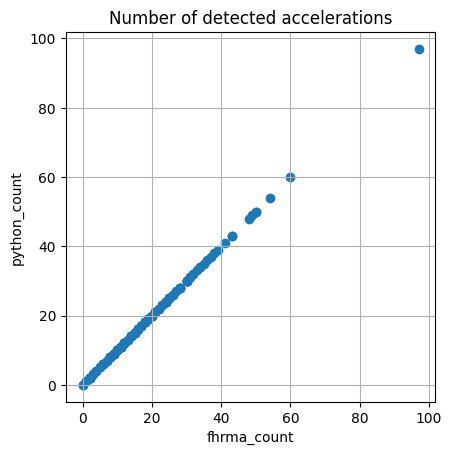

total_diff
0.0    156
Name: count, dtype: int64

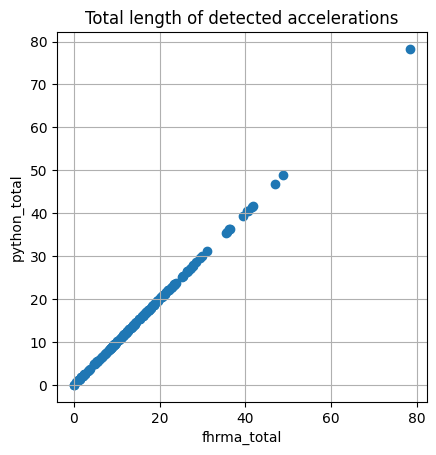

In [12]:
validation_against_fhrma(acc_result, 'accelerations')

#### Decelerations

In [13]:
dec_result = run_on_records(fhrma_maeda_dec, 'dec')
dec_result.head()

,record,fhrma,python,match
0,train28,"[[45.5875, 45.979166666666664], [46.0, 47.6666...","[[45.5875, 45.979166666666664], [46.0, 47.6666...",True
1,test80,"[[63.8625, 65.23333333333333], [65.3875, 66.02...","[[63.8625, 65.23333333333333], [65.3875, 66.02...",True
2,test68,"[[60.07083333333333, 60.4], [63.09583333333333...","[[60.07083333333333, 60.4], [63.09583333333333...",True
3,train04,"[[30.0, 30.579166666666666], [30.825, 31.55416...","[[30.0, 30.579166666666666], [30.825, 31.55416...",True
4,train31,"[[0.004166666666666667, 1.2541666666666667], [...","[[0.004166666666666667, 1.2541666666666667], [...",True


count_diff
0    156
Name: count, dtype: int64

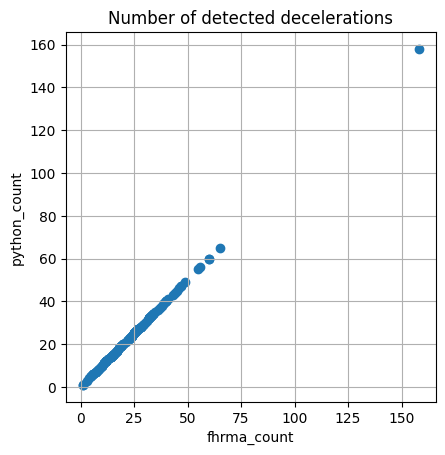

total_diff
0.0    156
Name: count, dtype: int64

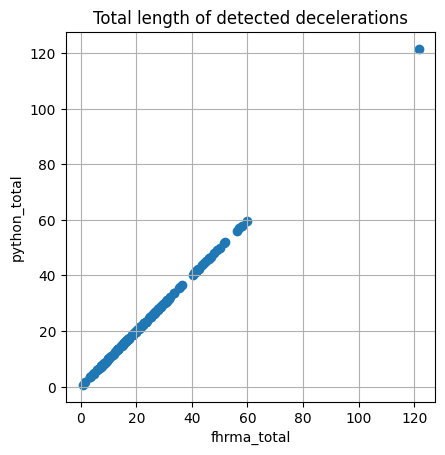

In [14]:
validation_against_fhrma(dec_result, 'decelerations')